# Results From Reverse Conway Game of Life Simulations using MPI


By: Justin Wijaya

*Make sure to have the MPI module loaded before running any of the commands in the notebook.*

## Serial Experiment

I compiled the serial code on amd20 using the following commands:

```
!gcc -lm -lpng -c reverseGOL.c
!gcc -lm -lpng -c png_util.c
!gcc -lm -lpng -o revGOL reverseGOL.o png_util.o
```
This process is simplified by using the premade makefile (which compiles the other versions of the code as well):

In [180]:
# Uncomment to run it directly
# !make

I ran the code 10 times with 
```bash
for iter in 1 2 3 4 5 6 7 8 9 10;
do
	SEED=$iter
	time ./revGOL cmse2.txt $SEED
done
```

Which is simplified by using the job script and command:

In [183]:
# !sbatch job.sb

and obtained the following results:

In [185]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

best1 = 274
times = [951.442,952.740,1037.567,956.013,952.705,956.509,956.449,958.304,956.321,951.102]
print("Best fitness:",best1)
print("Average runtime:",np.average(times),"seconds (",np.round(np.average(times)/60,2),"minutes )")

Best fitness: 274
Average runtime: 962.9152 seconds ( 16.05 minutes )


## Pleasantly Parallel Experiment

Using a job script, I ran the program on 50 CPUs using a simple job array.

This process can be replicated by running the following command:

In [189]:
# !sbatch job_array.sb

And obtained the following results:

In [191]:
best2 = 256
print("Best fitness:",best2)
print("Runtime:",921.994,"seconds")

Best fitness: 256
Runtime: 921.994 seconds


## Consolidated MPI Experiment (part one)

I modified the end of the program to have workers share their best result with the lead worker (rank == 0) and then have the lead worker print out the overall best result to the screen.

This process can be replicated by running the following command:

In [195]:
# !sbatch basic_mpi_job.sb

And obtained the following results:

In [198]:
best3 = 287
print("Best fitness:",best3)
print("Runtime:",765.276,"seconds")

Best fitness: 287
Runtime: 765.276 seconds


##  Sharing MPI Experiment (part two)

I modified the program after each generation and before the mutation to make a worker share its best result so far with its neighbor (using round robin). It replaces the current best with its neighbors if the neighbor's fitness score is better, and sets its former best as second best.

This process can be replicated by running the following command:

In [201]:
# !sbatch mpi_job.sb

And obtained the following results:

In [204]:
best4 = 284
print("Best fitness:",best4)
print("Runtime:",20.968,"seconds")

Best fitness: 284
Runtime: 20.968 seconds


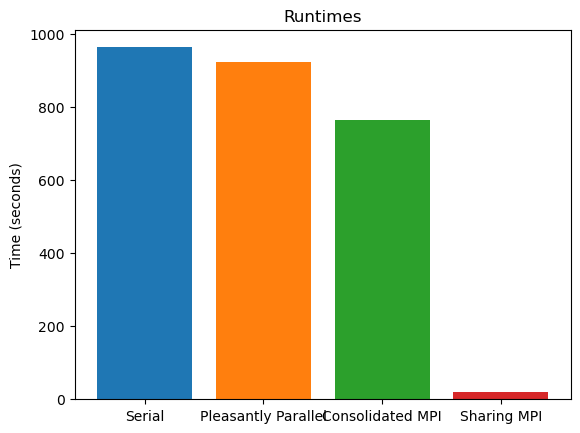

In [206]:
plt.title("Runtimes")
plt.bar('Serial',np.average(times))
plt.bar('Pleasantly Parallel',921.994)
plt.bar('Consolidated MPI',765.276)
plt.bar('Sharing MPI',20.968)
plt.ylabel('Time (seconds)')
plt.show()

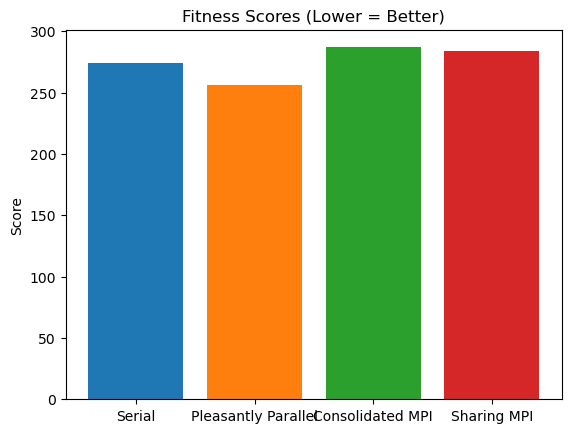

In [208]:
plt.title("Fitness Scores (Lower = Better)")
plt.bar('Serial',best1)
plt.bar('Pleasantly Parallel',best2)
plt.bar('Consolidated MPI',best3)
plt.bar('Sharing MPI',best4)
plt.ylabel('Score')
plt.show()

The runtimes displayed are expected (speedup with every modfication). However, the fitness scores were surprising. It appears that the utilization of MPI has caused the resulting 'best' fitness scores to be higher than when using serial code.

## Concluding Discussion

Describe what you learned during this process, what worked, what didn't work, where did you have trouble and what you learned

- I learned that though the utilization of MPI makes the program run way faster (~20 seconds as opposed to the serial ~16 minutes), it may not output the most accurate result (though the idea that it's simply an implementation error is not unreasonable).
    - In short, there is a tradeoff in computation time and accuracy when parallelizing.
- What worked was chunking the process so that one worker is focused on working on a chunk of the generations as opposed to having every worker run the entire process.
- What didn't work was as mentioned before; having every worker run the same process and comparing fitness scores afterwards. That led to a slowdown in its runtime.
- I had trouble in understanding where to implement MPI in the serial code. Through a deeper dive into what exactly the code is doing, I found that implementing MPI became way easier when armed with that knowledge.

----